# Big-Five Factor Markers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import train_test_split,cross_val_predict

#Modelling
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier

#Testing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score

# Data Overview

## DataLoad

In [2]:
categorical_columns = [f"EXT{i}" for i in range(1, 11)] + \
                      [f"EST{i}" for i in range(1, 11)] + \
                      [f"AGR{i}" for i in range(1, 11)] + \
                      [f"CSN{i}" for i in range(1, 11)] + \
                      [f"OPN{i}" for i in range(1, 11)] + \
                      ['target']

float32_columns = [f"EXT{i}_E" for i in range(1, 11)] + \
                  [f"EST{i}_E" for i in range(1, 11)] + \
                  [f"AGR{i}_E" for i in range(1, 11)] + \
                  [f"CSN{i}_E" for i in range(1, 11)] + \
                  [f"OPN{i}_E" for i in range(1, 11)]

cat_types = {k: 'category' for k in categorical_columns}
float32_types = {k: 'float32' for k in float32_columns}
dtype = {**float32_types, **float32_types}
#dtype = {**cat_types, **float32_types}

df = pd.read_csv('dataset/BigFivePersonalityTest-TrainSet.csv', parse_dates = ['dateload'], dtype=dtype)
df.rename(columns={'Unnamed: 0':'id'},inplace = True)
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 999
df.head()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err,target
0,441310,3.00,3.00,3.00,3.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,3.00,4.00,3.00,4.00,4.00,4.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,5.00,0.00,4.00,4.00,4.00,3.00,3.00,3.00,3.00,4.00,3.00,4.00,3.00,4.00,3.00,2.00,3.00,4.00,3.00,4.00,1.00,4.00,3.00,4.00,3.00,"6,462.00","2,273.00","1,625.00","4,960.00","6,040.00","3,983.00","3,608.00","3,376.00","3,216.00","4,544.00","2,913.00","13,480.00","3,008.00","3,496.00","4,640.00","2,274.00","2,080.00","2,535.00","2,545.00","1,719.00","5,432.00","4,696.00","2,319.00","1,944.00","5,008.00","2,698.00",0.00,"23,048.00","2,040.00","3,608.00","2,528.00","4,008.00","2,361.00","2,528.00","2,760.00","7,662.00","4,736.00","2,697.00","2,095.00","1,704.00","2,958.00","2,471.00","2,184.00","1,880.00","3,024.00","2,375.00","2,456.00","1,840.00","2,016.00","2,232.00",2017-06-25 19:21:21,"1,920.00","1,080.00",7.00,186.00,21,1,US,35.057,-79.0147,C
1,985842,3.00,4.00,4.00,3.00,2.00,3.00,5.00,2.00,4.00,4.00,3.00,4.00,4.00,1.00,2.00,2.00,4.00,4.00,4.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,4.00,5.00,3.00,3.00,3.00,2.00,2.00,4.00,3.00,3.00,3.00,2.00,4.00,1.00,5.00,1.00,4.00,1.00,5.00,4.00,4.00,5.00,"35,691.00","2,218.00","1,492.00","1,685.00","2,667.00","1,757.00","3,513.00",906.00,"1,211.00","2,013.00","1,401.00","2,884.00","1,100.00","1,276.00","1,416.00","5,026.00","1,142.00","1,518.00","1,761.00","2,382.00","1,426.00",995.00,"1,873.00","1,705.00","1,259.00","1,215.00","1,607.00","2,478.00","1,115.00","1,064.00","1,618.00","2,390.00","1,139.00","1,925.00","1,356.00","3,875.00","1,291.00","2,916.00","1,315.00","2,181.00","1,122.00",834.00,"2,201.00","10,365.00","1,283.00","1,490.00","2,185.00","1,318.00","1,227.00","1,247.00",2018-10-24 08:10:07,"1,366.00",768.00,15.00,133.00,7,14,SG,1.2931,103.8558,N
2,628988,3.00,3.00,2.00,3.00,2.00,3.00,1.00,2.00,2.00,5.00,2.00,4.00,2.00,1.00,4.00,3.00,2.00,3.00,4.00,4.00,3.00,4.00,1.00,2.00,4.00,4.00,2.00,2.00,4.00,3.00,2.00,2.00,2.00,4.00,1.00,4.00,4.00,4.00,0.00,2.00,2.00,2.00,5.00,1.00,3.00,2.00,3.00,3.00,4.00,4.00,"30,932.00","2,514.00","4,927.00","8,252.00","7,885.00","3,500.00","3,973.00","1,231.00","1,117.00","1,309.00",985.00,926.00,"1,133.00","5,290.00","33,489.00","3,101.00","2,600.00","12,058.00","6,068.00",684.00,"13,743.00","1,823.00","2,268.00","2,891.00","4,402.00","4,891.00","6,840.00","2,899.00","11,554.00","2,416.00","2,498.00","3,435.00","11,042.00","12,779.00","1,510.00","4,093.00","4,769.00","12,279.00",0.00,"9,355.00","4,027.00","4,616.00","1,974.00","2,000.00","3,203.00","4,126.00","2,514.00","4,169.00","1,800.00","5,787.00",2018-02-26 18:56:06,"1,680.00","1,050.00",3.00,286.00,16,11,HK,22.25,114.1667,N
3,704960,3.00,3.00,2.00,3.00,3.00,4.00,1.00,3.00,4.00,5.00,4.00,2.00,5.00,3.00,2.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,4.00,4.00,2.00,5.00,2.00,3.00,4.00,5.00,3.00,5.00,5.00,3.00,2.00,4.00,1.00,2.00,5.00,3.00,3.00,4.00,3.00,3.00,3.00,2.00,3.00,3.00,5.00,3.00,"8,624.00","2,872.00","5,600.00","3,152.00","5,775.00","1,753.00","4,208.00","5,648.00","7,136.00","1,704.00","2,361.00","7,576.00","2,360.00","5,584.00","3,328.00","2,728.00","2,567.00","2,880.00","1,120.00","4,376.00","3,113.00","1,681.00","2,400.00","3,415.00","3,921.00","3,120.00","4,672.00","4,344.00","4,064.00","3,457.00","3,071.00","2,920.00","2,792.00","1,9

In [3]:
print(f'Train dataset has {df.shape[0]} rows and {df.shape[1]} features.')
df.describe()

Train dataset has 964573 rows and 112 features.


,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"964,573.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,611.00","962,611.00","962,611.00","962,863.00","964,573.00","964,573.00"
mean,"507,687.98",2.65,2.77,3.29,3.14,3.28,2.40,2.77,3.41,2.96,3.56,3.29,3.16,3.85,2.66,2.84,2.84,3.05,2.68,3.09,2.77,2.26,3.83,2.26,3.93,2.27,3.74,2.20,3.69,3.79,3.59,3.30,2.93,3.98,2.62,2.63,2.83,3.70,2.47,3.20,3.59,3.65,2.08,4.00,2.00,3.79,1.89,3.98,3.18,4.12,3.96,"98,303.90","7,868.34","11,745.72","7,488.71","7,204.35","7,520.51","11,095.22","7,097.06","6,189.11","7,556.75","9,611.44","9,304.36","7,805.62","10,855.95","10,405.29","8,276.98","6,979.06","8,080.31","5,464.28","4,760.57","18,399.51","8,656.28","6,649.63","9,090.83","11,311.81","6,211.18","8,382.48","9,099.23","5,352.74","6,098.79","12,310.78","10,173.75","8,854.17","9,184.09","9,131.42","11,617.35","5,615.05","10,904.71","5,500.40","11,005.06","8,574.33","13,270.75","7,135.83","13,599.01","6,264.19","8,307.59","7,780.77","5,470.92","6,385.60","5,428.93","1,149.46",826.32,957.42,660.47,"2,777.03",10.45
std,"293,090.74",1.26,1.32,1.22,1.24,1.28,1.23,1.40,1.27,1.35,1.31,1.35,1.23,1.16,1.25,1.27,1.33,1.29,1.34,1.30,1.32,1.34,1.14,1.28,1.13,1.17,1.22,1.12,1.10,1.17,1.08,1.18,1.39,1.04,1.25,1.27,1.42,1.13,1.14,1.28,1.05,1.16,1.11,1.10,1.09,0.99,1.10,1.01,1.26,1.04,1.03,"4,992,401.50","441,714.69","2,386,077.75","326,273.72","616,677.00","580,364.75","2,246,859.25","377,292.97","254,007.56","2,200,702.25","1,273,595.25","638,532.81","726,467.69","1,131,015.38","2,235,275.75","719,566.44","398,919.06","2,210,038.50","449,060.94","174,032.91","1,772,232.62","722,187.31","263,899.03","773,435.00","2,235,321.00","343,937.00","684,252.94","1,436,147.25","163,695.05","312,378.41","1,335,930.00","576,368.50","1,246,966.62","731,616.06","1,040,988.88","2,291,148.50","275,729.19","513,744.66","414,599.50","2,262,755.75","955,851.50","1,253,111.75","372,066.84","3,126,721.50","343,716.78","574,789.44","598,264.56","269,737.75","440,852.66","452,223.84",560.05,180.26,"51,912.03","15,824.76","1,522,388.82",39.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

## Missing Values

In [4]:
df.drop(labels= ['id'],axis=1,inplace = True)
df.replace(to_replace = 0, value = np.nan,inplace = True)
df.isnull().sum()[df.isnull().sum()>0].to_frame('Nulls').sort_values(by = 'Nulls')/len(df)*100

,Nulls
country,0.01
target,0.18
testelapse,0.18
introelapse,0.21
screenh,0.47
...,...
AGR6_E,1.62
EST2_E,1.63
EST6_E,1.67
EST4_E,1.68


In [5]:
df.dropna(axis = 0,inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822925 entries, 1 to 964572
Columns: 111 entries, EXT1 to target
dtypes: datetime64[ns](1), float32(50), float64(54), int64(2), object(4)
memory usage: 546.2+ MB


## Data Exploration

### Columns in dataset

In [7]:
df.columns.values

array(['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8',
       'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6',
       'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3', 'AGR4',
       'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2',
       'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10',
       'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8',
       'OPN9', 'OPN10', 'EXT1_E', 'EXT2_E', 'EXT3_E', 'EXT4_E', 'EXT5_E',
       'EXT6_E', 'EXT7_E', 'EXT8_E', 'EXT9_E', 'EXT10_E', 'EST1_E',
       'EST2_E', 'EST3_E', 'EST4_E', 'EST5_E', 'EST6_E', 'EST7_E',
       'EST8_E', 'EST9_E', 'EST10_E', 'AGR1_E', 'AGR2_E', 'AGR3_E',
       'AGR4_E', 'AGR5_E', 'AGR6_E', 'AGR7_E', 'AGR8_E', 'AGR9_E',
       'AGR10_E', 'CSN1_E', 'CSN2_E', 'CSN3_E', 'CSN4_E', 'CSN5_E',
       'CSN6_E', 'CSN7_E', 'CSN8_E', 'CSN9_E', 'CSN10_E', 'OPN1_E',
       'OPN2_E', 'OPN3_E', 'OPN4_E', 'OPN5_E', 'OPN6_E', 'OPN7_E',
       'OPN8_E', 'OPN9_

## Question's Answer Distribution    

### Globally

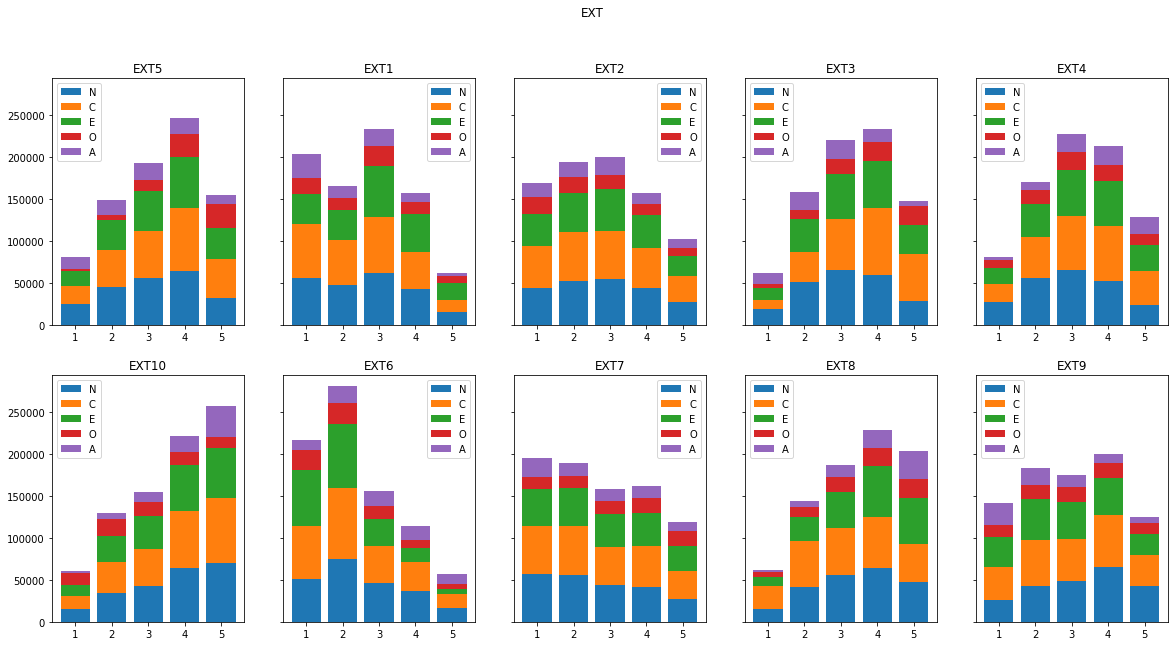

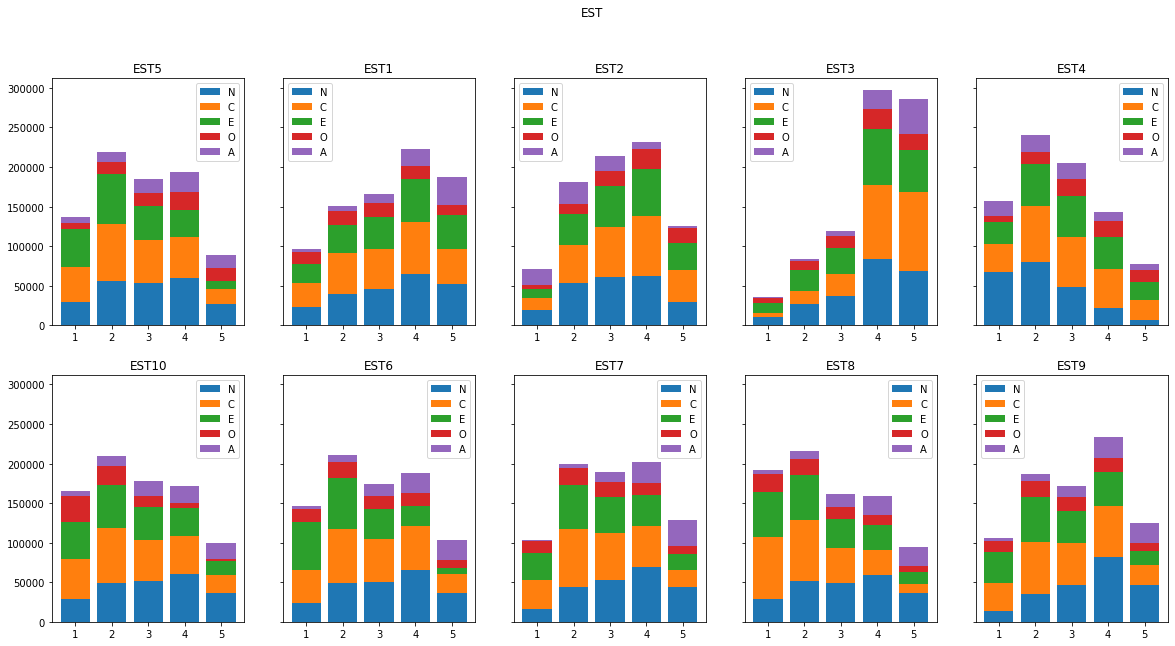

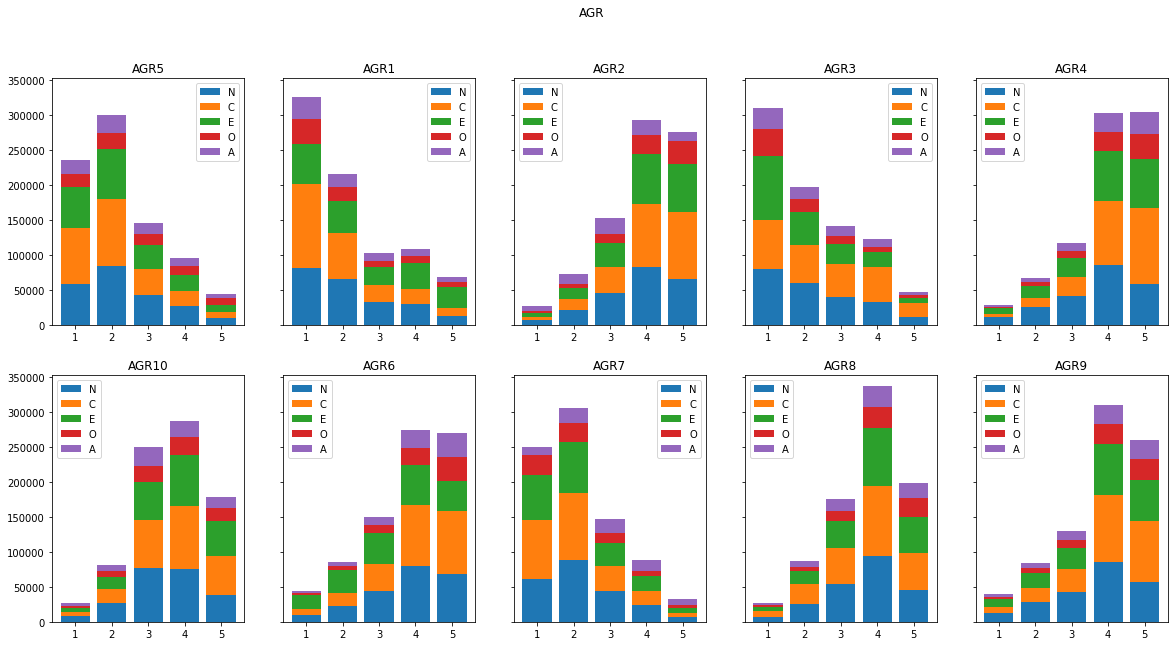

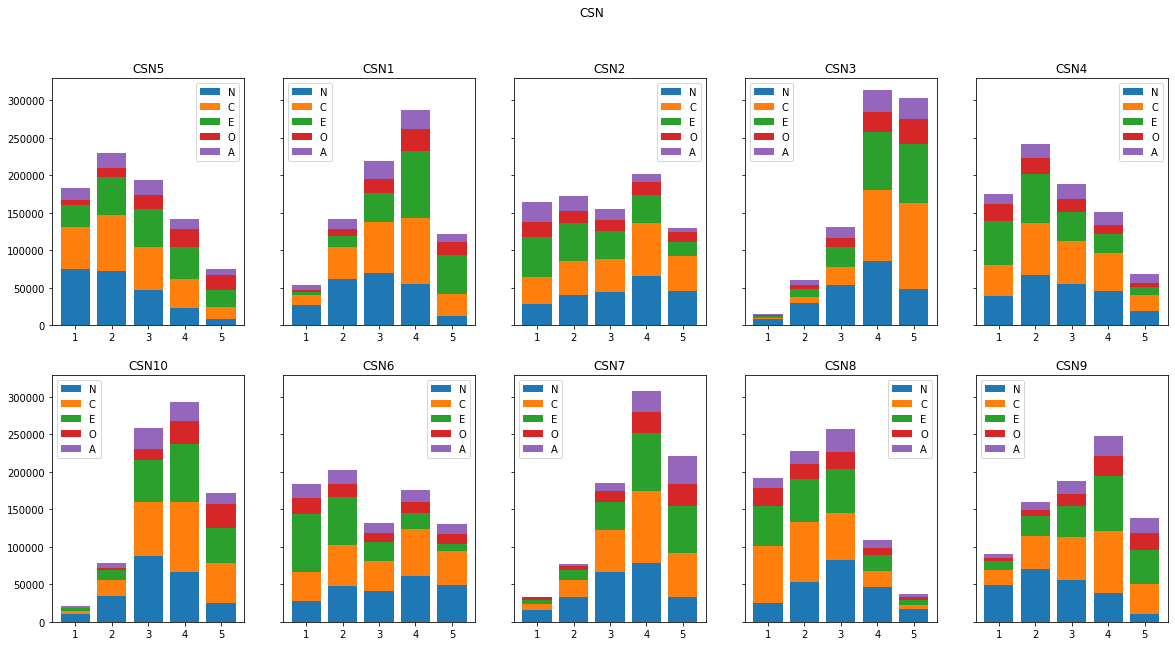

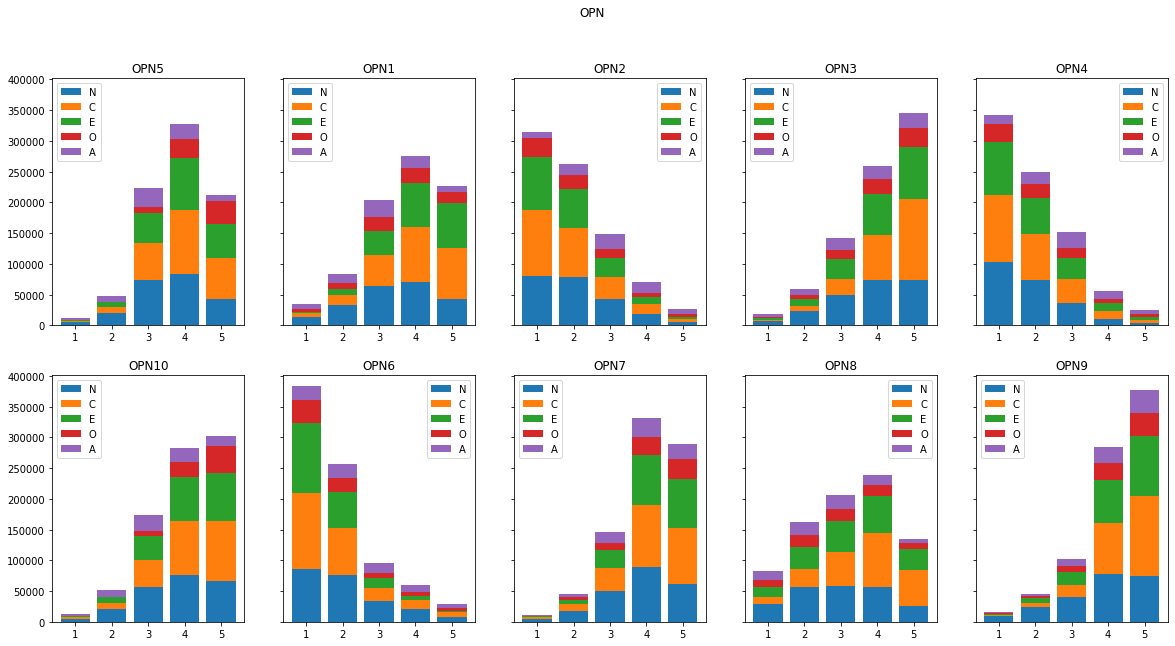

In [8]:
q_types = ['EXT', 'EST', 'AGR', 'CSN', 'OPN']
targets = df['target'].unique()

for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for i, question in enumerate(questions):
        ax = axis[round((i+1)/10), (i + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        cumsum = np.cumsum(targets_data, axis=0)
        for i in range(len(targets_data)):
            if i == 0:
                ax.bar(targets_data[i].index, targets_data[i], label=targets[i])
            else:
                ax.bar(targets_data[i].index, targets_data[i], bottom=cumsum[i - 1], label=targets[i])

            ax.legend()

### Per target

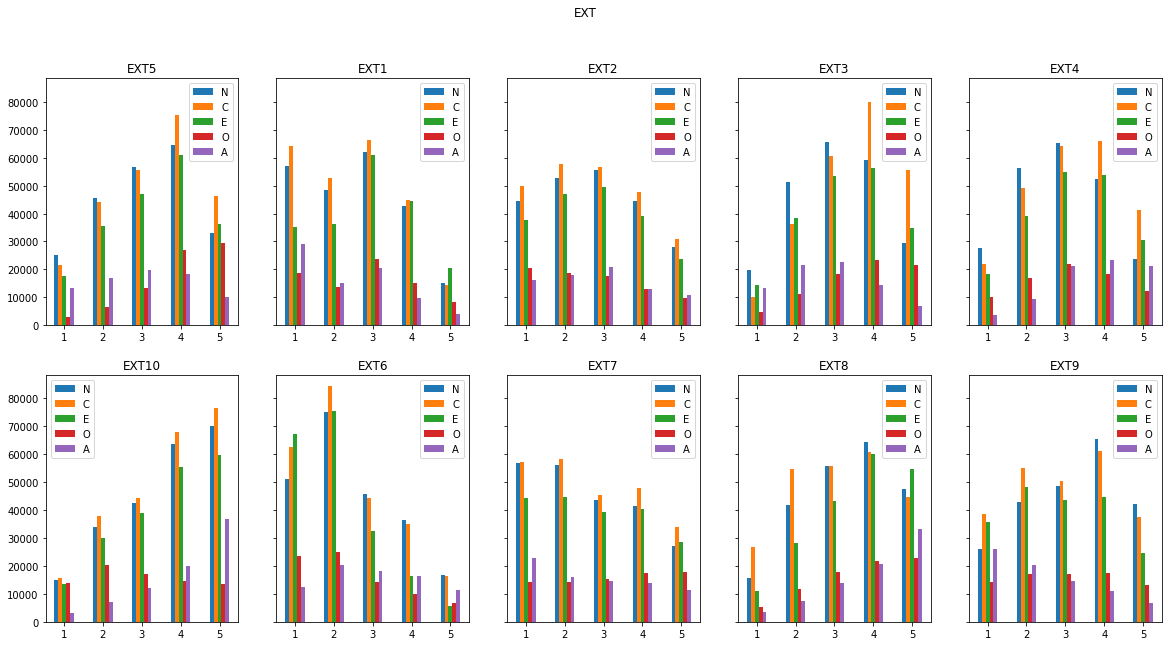

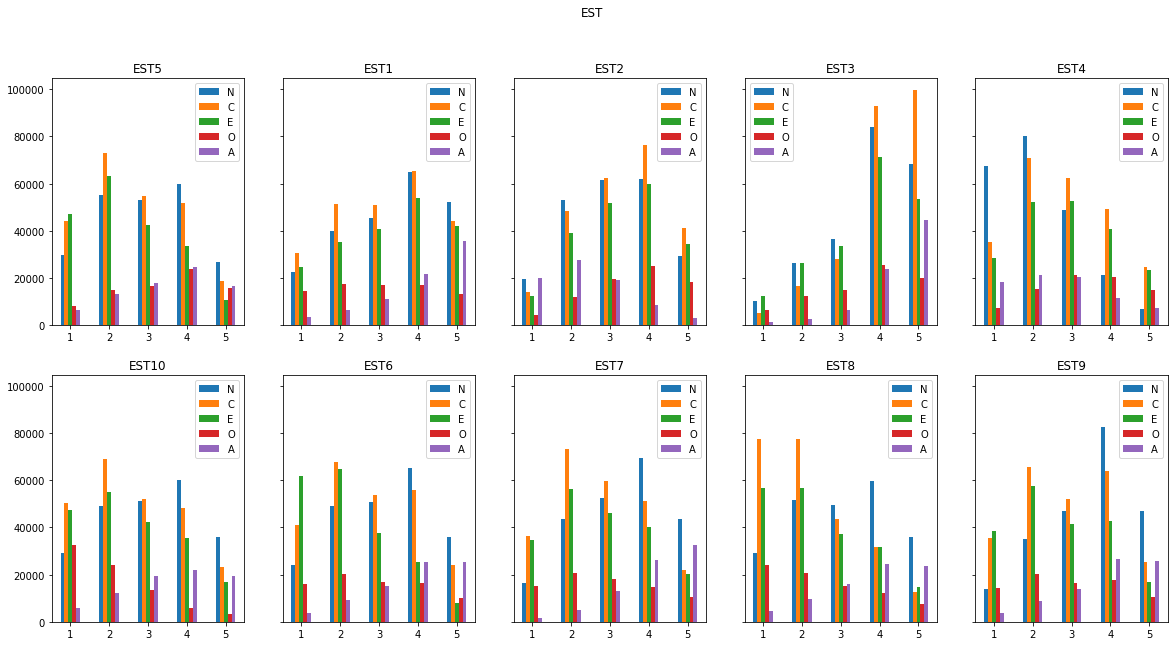

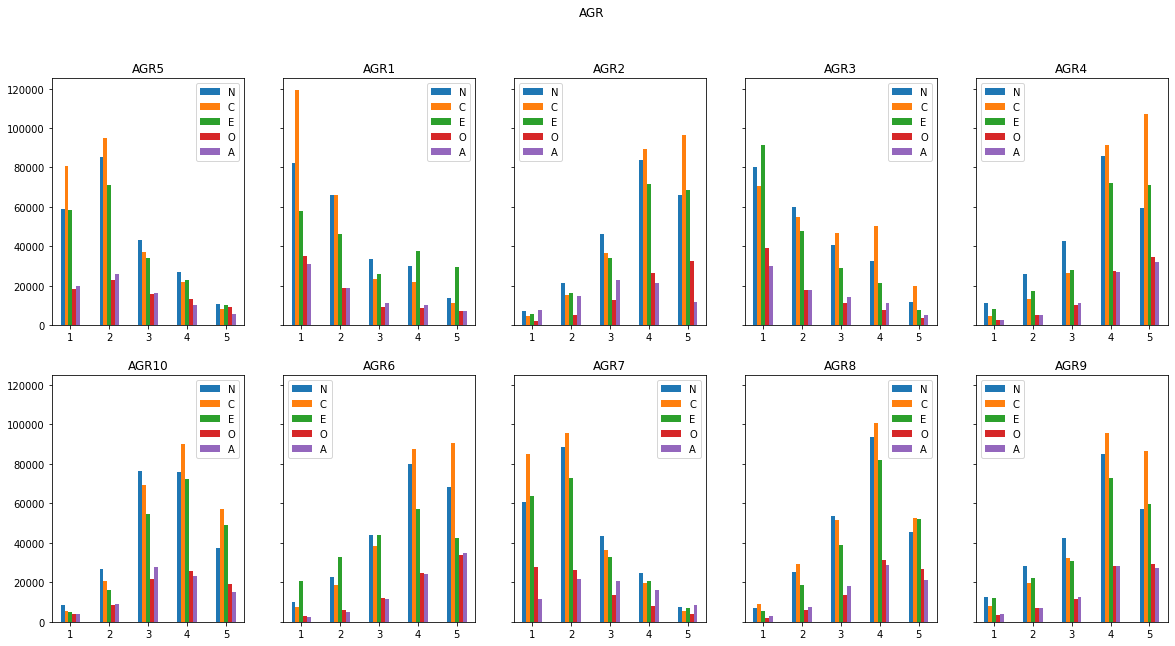

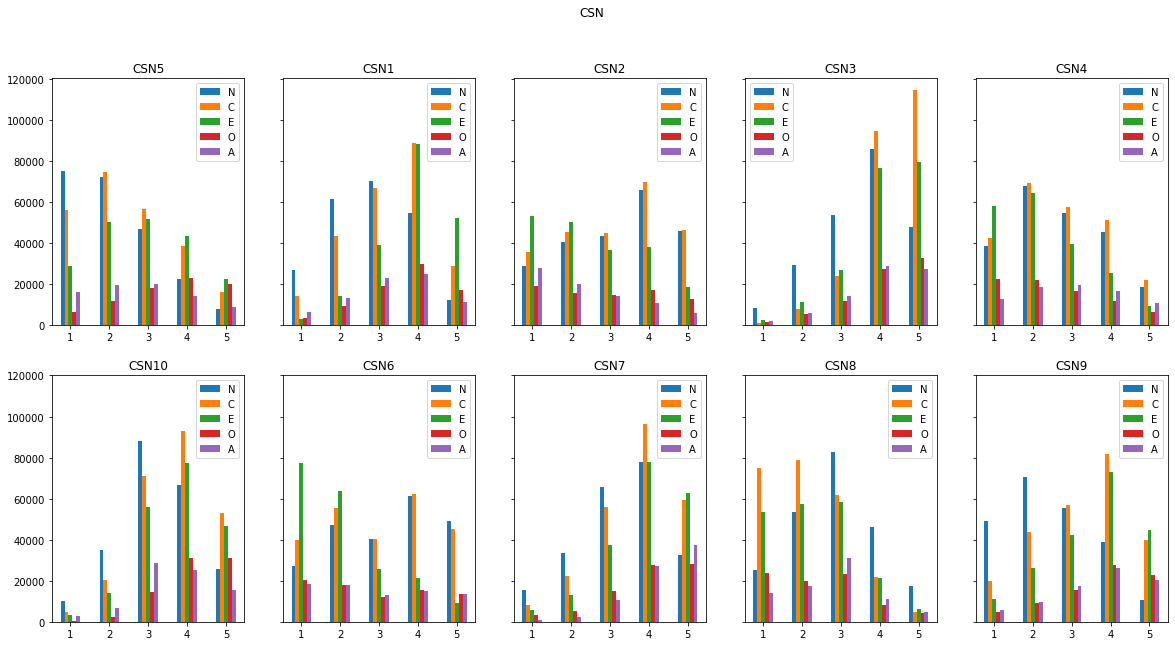

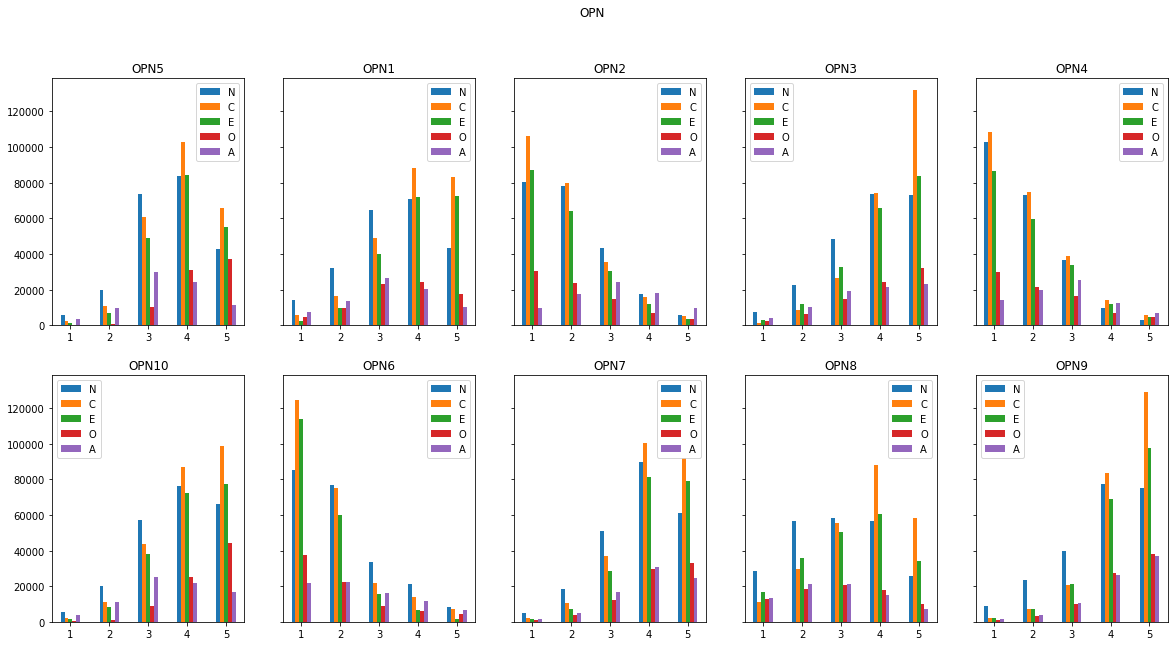

In [9]:
width = 0.1
for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for j, question in enumerate(questions):
        ax = axis[round((j+1)/10), (j + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        for i in range(len(targets_data)):
            ax.bar(targets_data[i].index + (i - 2) * width, targets_data[i], width, label=targets[i])
            ax.set_xticks(targets_data[i].index)
            ax.legend()

## Balance Of Target Variable

`Extroversion (E)`: Altos puntajes tienden a ser personas muy sociables, mientras que bajos puntajes prefieren trabajar solos en proyectos.  
`Agreeableness (A)`: Altos puntajes tienen a ser personas con comportamiento políticamente correcto, mientras que bajos puntajes tienden a ser personas muy directas.  
`Conscientiouness (C)`: Altos puntajes tienen a ser personas que siguen las reglas y prefieren el orden, mientras que bajos puntajes tienden a ser personas desordenadas.  
`Neuroticism (N)`: El nivel “ser emocional” de una persona.  
`Openness to Experience (O)`: Altos puntajes tienden a ser personas que “sueñan despiertas”, mientras que bajos puntajes tienden a “estar con los pies sobre la tierra”.

C    242510
N    225175
E    197162
O     79375
A     78703
Name: target, dtype: int64


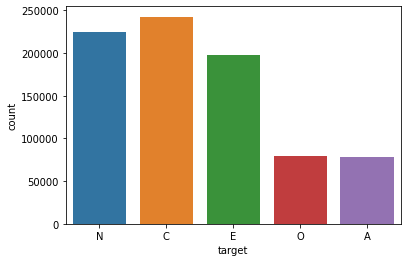

In [10]:
print(df['target'].value_counts())
sns.countplot('target',data = df)
plt.show()

## Data Transformation
- Conversion of milliseconds to minutes  
- Drop of outliers using IQR

In [11]:
df_columns = df.columns
time_columns = []

for col in df_columns:
    if '_E' in str(col):
        time_columns.append(col)
        df[col] = df[col].apply(lambda x: abs(x/1000/60))
        q1 = df[col].quantile(0.25)
        q2 = df[col].quantile(0.50)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = df[col].apply(lambda x: q2 if (x>=q3 + 1.5*iqr) else x)

In [12]:
df.describe()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00","822,925.00"
mean,2.65,2.79,3.30,3.17,3.30,2.41,2.78,3.44,2.98,3.59,3.31,3.20,3.87,2.69,2.85,2.87,3.06,2.69,3.10,2.79,2.25,3.87,2.27,3.96,2.28,3.78,2.21,3.72,3.81,3.62,3.34,2.95,4.00,2.63,2.63,2.84,3.73,2.48,3.22,3.63,3.70,2.07,4.04,2.00,3.82,1.90,4.02,3.22,4.17,3.98,0.13,0.06,0.06,0.06,0.05,0.05,0.08,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.06,0.06,0.06,0.05,0.05,0.05,0.08,0.06,0.06,0.06,0.07,0.05,0.06,0.07,0.06,0.06,0.06,0.07,0.06,0.06,0.06,0.08,0.05,0.07,0.05,0.07,0.05,0.07,0.05,0.07,0.05,0.06,0.06,0.05,0.06,0.04,"1,144.12",827.60,980.96,624.92,"3,095.41",10.00
std,1.25,1.31,1.19,1.21,1.24,1.21,1.38,1.24,1.32,1.27,1.32,1.19,1.13,1.23,1.25,1.30,1.27,1.32,1.27,1.31,1.32,1.08,1.27,1.08,1.15,1.16,1.10,1.04,1.13,1.03,1.12,1.37,1.00,1.23,1.25,1.40,1.08,1.12,1.25,1.00,1.10,1.09,1.04,1.07,0.93,1.08,0.94,1.22,0.97,0.99,0.07,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.04,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.04,0.02,0.03,0.03,0.03,0.02,0.03,0.02,0.03,0.03,0.02,0.03,0.02,560.82,175.61,"55,225.31","16,359.77","1,648,074.31",37.93
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,3.00,2.00,2.00,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,1.00,3.00,1.00,3.00,1.00,3.00,3.00,3.00,3.00,2.00,3.00,2.00,2.00,2.00,3.00,2.00,2.00,3.00,3.00,1.00,3.00,1.00,3.00,1.00,4.00,2.00,4.00,3.00,0.08,0.04,0.04,0.04,0.04,0.04,0.05,0.04,0.04,0.

## Feature Selection

In [13]:
labels = ['dateload','screenw','screenh','introelapse','testelapse','endelapse','IPC','country','lat_appx_lots_of_err','long_appx_lots_of_err']
df.drop(labels = labels, inplace = True, axis =1)

In [14]:
le = LabelEncoder()
le.fit(list(df['target'].unique()))
le.classes_
df['target'] = le.transform(df['target'])

In [15]:
X = df.drop('target',axis=1)
y = df['target']

bestfeatures = SelectKBest(score_func=chi2, k=52)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(52,'Score'))

   Feature     Score
17    EST8 62,879.49
35    CSN6 56,973.29
15    EST6 55,046.56
38    CSN9 51,709.59
34    CSN5 46,085.13
16    EST7 44,817.02
19   EST10 41,723.46
41    OPN2 39,691.30
18    EST9 37,909.29
30    CSN1 35,380.77
13    EST4 34,396.35
31    CSN2 31,691.60
45    OPN6 29,692.44
37    CSN8 27,579.74
43    OPN4 26,844.05
14    EST5 26,645.61
20    AGR1 26,484.28
47    OPN8 24,086.23
11    EST2 23,988.56
40    OPN1 20,848.80
5     EXT6 19,359.11
26    AGR7 18,161.37
22    AGR3 17,385.54
36    CSN7 16,609.99
10    EST1 16,425.51
2     EXT3 15,997.66
8     EXT9 15,588.80
32    CSN3 14,935.71
25    AGR6 14,848.74
39   CSN10 14,386.02
4     EXT5 14,049.73
9    EXT10 13,964.08
12    EST3 13,858.45
33    CSN4 13,573.16
44    OPN5 12,688.19
21    AGR2 12,665.33
7     EXT8 12,535.12
49   OPN10 12,455.26
42    OPN3 11,997.66
0     EXT1  9,465.40
3     EXT4  9,334.87
24    AGR5  9,207.03
48    OPN9  9,122.24
23    AGR4  7,067.11
6     EXT7  4,923.78
46    OPN7  4,295.67
28    AGR9  3

In [16]:
df.drop(labels = time_columns, axis=1,inplace = True)

## Modelling - UnderSampling

Let's fit different models and compare the results between them. First, let's create our training and test sets. Since we have a rather strong imbalance in our data, we are going to create our train/test sets based on a subset of total data in which every target value has the same proportion.

In [17]:
min_target = df['target'].value_counts().min()
features = pd.DataFrame()

for label in df['target'].unique():
    label_data = df[df['target'] == label].sample(n=min_target)
    features = pd.concat([features, label_data], axis=0)

labels = features['target']
features = features.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features.values,labels.values,test_size=0.2,random_state=0,shuffle=True)

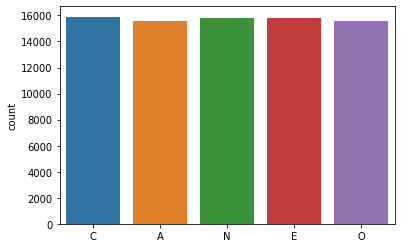

In [18]:
sns.countplot(le.inverse_transform(y_test))
plt.show()

Create a dictionary to store the trained models.

In [19]:
models = {}

### Simple Logistic Regression

In [20]:
logistic = LogisticRegression(n_jobs=-1, max_iter=300,random_state=0)
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

### SGD Classifier

In [21]:
sgd = SGDClassifier(random_state=0,alpha=1e-5,epsilon=1e-2,average=True,loss='log',early_stopping=True)
sgd.fit(X_train,y_train)
models[str(type(sgd).__name__)] = sgd

### Bayes Classifier

In [22]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
models[str(type(bayes).__name__)] = bayes

### Random Forest

In [23]:
randomf = RandomForestClassifier(criterion='gini',n_estimators=150,random_state=0,max_depth=5)
randomf.fit(X_train,y_train)
models[str(type(randomf).__name__)] = randomf

## Error Analysis

### Confusion Matrix

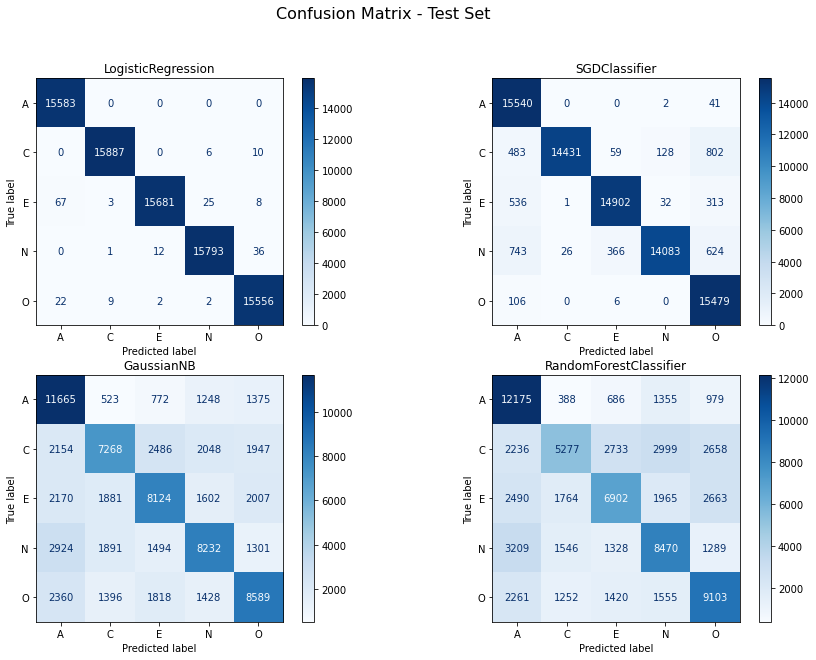

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.suptitle('Confusion Matrix - Test Set',fontsize=16)

for model, ax in zip(models, axes.flatten()):
    estimator = models[str(model)]
    
    plot_confusion_matrix(estimator, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels=le.inverse_transform([0, 1, 2, 3, 4]))
    ax.title.set_text(type(estimator).__name__)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.show()

### Classification Report

In [25]:
for model in models:
     
    estimator = models[str(model)]
    y_pred = models[str(model)].predict(X_test)
    report = classification_report(y_test,y_pred,target_names=le.inverse_transform([0,1,2,3,4]),output_dict=True)
    clsf_report = pd.DataFrame(report).transpose()
    print(model)
    print(clsf_report)
    print()

LogisticRegression
              precision  recall  f1-score   support
A                  0.99    1.00      1.00 15,583.00
C                  1.00    1.00      1.00 15,903.00
E                  1.00    0.99      1.00 15,784.00
N                  1.00    1.00      1.00 15,842.00
O                  1.00    1.00      1.00 15,591.00
accuracy           1.00    1.00      1.00      1.00
macro avg          1.00    1.00      1.00 78,703.00
weighted avg       1.00    1.00      1.00 78,703.00

SGDClassifier
              precision  recall  f1-score   support
A                  0.89    1.00      0.94 15,583.00
C                  1.00    0.91      0.95 15,903.00
E                  0.97    0.94      0.96 15,784.00
N                  0.99    0.89      0.94 15,842.00
O                  0.90    0.99      0.94 15,591.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.95    0.95      0.95 78,703.00
weighted avg       0.95    0.95      0.95 78,703.00

GaussianNB
              prec

### Accuracy Score

In [26]:
for model in models:
    estimator = models[str(model)]
    y_pred = estimator.predict(X_test)
    print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),2))

LogisticRegression 1.0
SGDClassifier 0.95
GaussianNB 0.56
RandomForestClassifier 0.53


## Modelling - Over Sampling

In [27]:
sm = RandomOverSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])

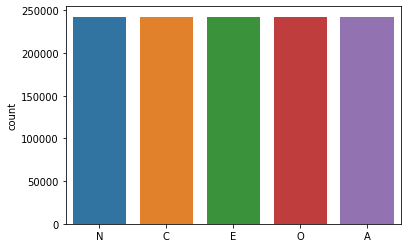

In [28]:
sns.countplot(le.inverse_transform(y_res))
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0,shuffle=True)

In [30]:
models_res = {}

In [31]:
logistic.fit(X_train, y_train)
models_res[str(type(logistic).__name__)] = logistic

In [32]:
sgd.fit(X_train,y_train)
models_res[str(type(sgd).__name__)] = sgd

In [33]:
bayes.fit(X_train, y_train)
models_res[str(type(bayes).__name__)] = bayes

In [34]:
randomf.fit(X_train,y_train)
models_res[str(type(randomf).__name__)] = randomf

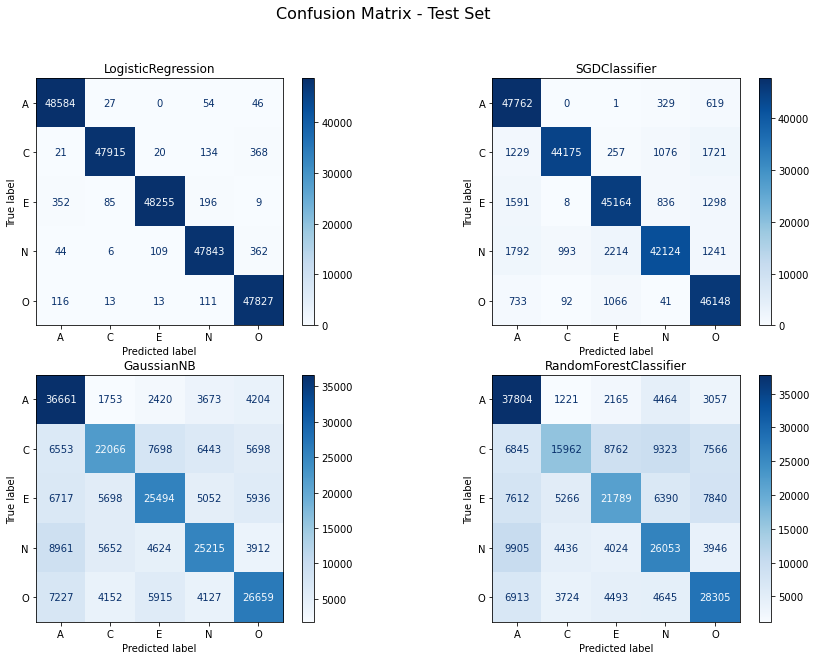

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.suptitle('Confusion Matrix - Test Set',fontsize=16)

for model, ax in zip(models_res, axes.flatten()):
    estimator = models_res[str(model)]
    
    plot_confusion_matrix(estimator, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels=le.inverse_transform([0, 1, 2, 3, 4]))
    ax.title.set_text(type(estimator).__name__)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.show()

In [36]:
for model in models_res:
     
    estimator = models_res[str(model)]
    y_pred = models_res[str(model)].predict(X_test)
    report = classification_report(y_test,y_pred,target_names=le.inverse_transform([0,1,2,3,4]),output_dict=True)
    clsf_report = pd.DataFrame(report).transpose()
    print(model)
    print(clsf_report)
    print()

LogisticRegression
              precision  recall  f1-score    support
A                  0.99    1.00      0.99  48,711.00
C                  1.00    0.99      0.99  48,458.00
E                  1.00    0.99      0.99  48,897.00
N                  0.99    0.99      0.99  48,364.00
O                  0.98    0.99      0.99  48,080.00
accuracy           0.99    0.99      0.99       0.99
macro avg          0.99    0.99      0.99 242,510.00
weighted avg       0.99    0.99      0.99 242,510.00

SGDClassifier
              precision  recall  f1-score    support
A                  0.90    0.98      0.94  48,711.00
C                  0.98    0.91      0.94  48,458.00
E                  0.93    0.92      0.93  48,897.00
N                  0.95    0.87      0.91  48,364.00
O                  0.90    0.96      0.93  48,080.00
accuracy           0.93    0.93      0.93       0.93
macro avg          0.93    0.93      0.93 242,510.00
weighted avg       0.93    0.93      0.93 242,510.00

GaussianNB


In [37]:
for model in models_res:
    estimator = models_res[str(model)]
    y_pred = estimator.predict(X_test)
    print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),2))

LogisticRegression 0.99
SGDClassifier 0.93
GaussianNB 0.56
RandomForestClassifier 0.54


## ROC Curve Analysis

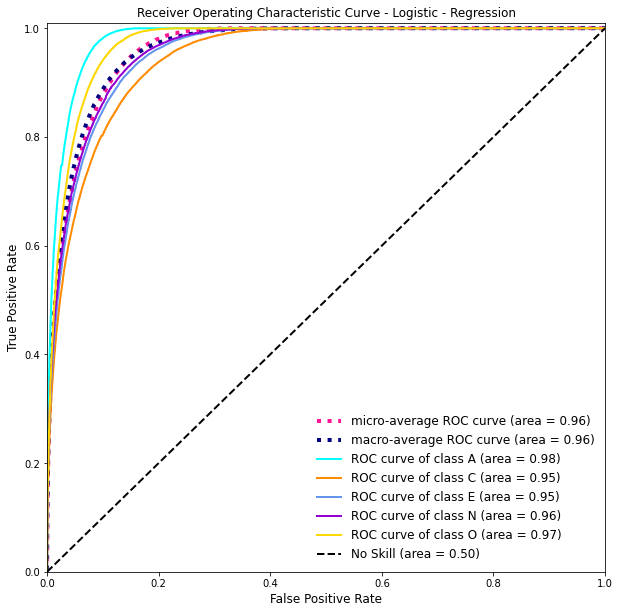

In [39]:

# Import some data to play with
X = X_res
y = y_res

# Binarize the output
y = label_binarize(y, classes=[0,1,2,3,4])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=0,shuffle=True)

# Learn to predict each class against the other
y_score = models_res['LogisticRegression'].decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10.1))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkviolet','gold'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'''.format(le.inverse_transform([i])[0], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,label='No Skill (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title(f'Receiver Operating Characteristic Curve - Logistic - Regression',fontsize=12)
plt.legend(loc="lower right",frameon=False,fontsize=12)
plt.show()